## Kaggle 可视化 （18/06/09）

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten,MaxPool2D,Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import itertools


### 查看数据基本情况

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data.info()
print('_____________________________________________________')
test_data.info()
batch_size = 256 # 在计算力允许的情况下，batch_size越大越好
nb_classes = 10
nb_epoch = 30

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
_____________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
# isnull()判断是否有缺失值；
# any()返回是否有任何元素在请求轴上为真（会将DataFrame转为Series）,若axis=0则以columns为单位，若axis=1则以index为单位,axis默认为0；
# describe()对数据进行描述性统计（对象属性会返回count计数和，unique不重复的值的数量，top最常见的值的value，freq最常见的值的频率）

print(train_data.isnull().any().describe())
print('_____________________________________________________')
print(test_data.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
_____________________________________________________
count       784
unique        1
top       False
freq        784
dtype: object


### 数据预处理

(42000, 28, 28, 1)
(28000, 28, 28, 1)
Train Sample: 42000
Test Sample: 28000


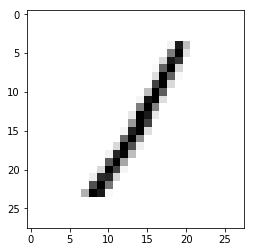

In [5]:
X_train=train_data.drop(columns=['label'])
Y_train=train_data.label
del train_data
# 改变维度：第一个参数是图片数量，后三个参数是每个图片的维度
X_train = X_train.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print(X_train.shape)
print(test_data.shape)
print("Train Sample:",X_train.shape[0])
print("Test Sample:",test_data.shape[0])
# 归一化：将数据进行归一化到0-1 因为图像数据最大是255
X_train=X_train/255.0
test_data=test_data/255.0
# 将类别向量(从0到nb_classes的整数向量)映射为二值类别矩阵
Y_train = to_categorical(Y_train, num_classes = nb_classes)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1)
plt.imshow(X_train[0][:,:,0], cmap="Greys")
plt.show()

### 建立模型

In [6]:
model = Sequential()
# filters：卷积核的数目（即输出的维度）
# kernel_size：卷积核的宽度和长度。如为单个整数，则表示在各个空间维度的相同长度。
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# 上面的MaxPooling2D层之后添model.add(Flatten())，Keras能自己分析出输入和输出的维度。
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
# 全连接层可以通过Dense指出，指明输出神经元个数和激活函数即可
model.add(Dropout(0.5))
# 输出层也是dense
model.add(Dense(10, activation = "softmax"))

In [9]:
#plot_model(model)

### 数据扩增

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [11]:
# 学习率的设置
# monitor：被监测的量
# factor：每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
# patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
# mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率的下限

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [12]:
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 使用多类的对数损失categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# history=model.fit(X_train,Y_train,
#           batch_size=batch_size,
#           epochs=nb_epoch,
#           verbose=2,
#           validation_data=(X_val,Y_val))


# ImageDataGenerator需要和fir_generator配合，才能实时进行数据扩增
# 当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =nb_epoch, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size+1,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 11s - loss: 0.9409 - acc: 0.6850 - val_loss: 0.1464 - val_acc: 0.9564
Epoch 2/30
 - 5s - loss: 0.3182 - acc: 0.9020 - val_loss: 0.0765 - val_acc: 0.9774
Epoch 3/30
 - 5s - loss: 0.2043 - acc: 0.9392 - val_loss: 0.0525 - val_acc: 0.9836
Epoch 4/30
 - 5s - loss: 0.1525 - acc: 0.9533 - val_loss: 0.0486 - val_acc: 0.9838
Epoch 5/30
 - 5s - loss: 0.1242 - acc: 0.9624 - val_loss: 0.0525 - val_acc: 0.9833
Epoch 6/30
 - 5s - loss: 0.1040 - acc: 0.9686 - val_loss: 0.0378 - val_acc: 0.9886
Epoch 7/30
 - 5s - loss: 0.0921 - acc: 0.9724 - val_loss: 0.0328 - val_acc: 0.9895
Epoch 8/30
 - 5s - loss: 0.0849 - acc: 0.9751 - val_loss: 0.0215 - val_acc: 0.9936
Epoch 9/30
 - 5s - loss: 0.0786 - acc: 0.9767 - val_loss: 0.0260 - val_acc: 0.9917
Epoch 10/30
 - 5s - loss: 0.0748 - acc: 0.9770 - val_loss: 0.0283 - val_acc: 0.9921
Epoch 11/30
 - 5s - loss: 0.0688 - acc: 0.9793 - val_loss: 0.0216 - val_acc: 0.9943
Epoch 12/30
 - 5s - loss: 0.0677 - acc: 0.9811 - val_loss: 0.0232 - val_acc: 0.9926


In [13]:
score = model.evaluate(X_val, Y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.0151633506642
Val accuracy: 0.995


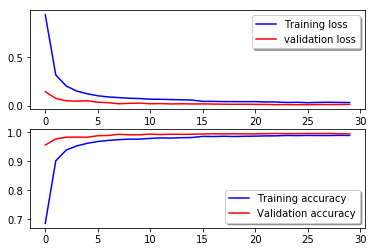

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
plt.show()

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 是否进行标准化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

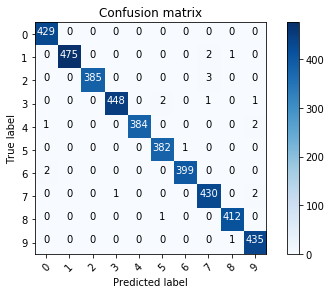

In [18]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [19]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap="Greys")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

In [20]:
errors = (Y_pred_classes - Y_true != 0)  # 矩阵相减得到误差集（?*1）
# 使用布尔索引
Y_pred_classes_errors = Y_pred_classes[errors]  # 误差集的预测标签Y（?*1）
Y_pred_errors = Y_pred[errors]  # 误差集的预测序列（?*10）
Y_true_errors = Y_true[errors]  # 误差集的真实标签Y（?*1）
X_val_errors = X_val[errors]  # 误差集的特征X，即数字图片（?*28*28*1）

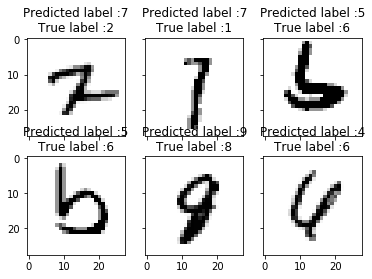

Begin to predict for testing data ...


In [26]:
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# 误差集中对真实标签的预测概率，np.diagonal是返回对角线的元素
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# 排序并返回的是数组值从小到大的索引值
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [ ]:
# '预测测试集'''
print('Begin to predict for testing data ...')
results = model.predict(test_data)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submit.csv",index=False)
print('over')